# Final Project — Airline Delay Analysis

**Author:** Shilpa Golla  
**Course:** Machine Learning  
**Dataset:** `DelayedFlights.csv` (Airline Delay Causes dataset)  
**Date:** 2025-10-06

## Abstract
This notebook analyzes flight delay patterns and builds a predictive model for whether a flight will be **delayed on arrival** (delay > 15 minutes).  
We follow a clear reproducible pipeline: data loading → cleaning → EDA → feature engineering → modeling → evaluation → interpretation → recommendations.

**Notebook structure**
- Setup & imports
- Data inspection & cleaning
- Exploratory Data Analysis (EDA)
- Feature engineering
- Modeling (classification: delayed vs not delayed)
- Evaluation and interpretation
- Recommendations, limitations and presentation notes


#### Install / Requirements

In [2]:
!pip install pandas numpy matplotlib seaborn scikit-learn joblib shap

  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached colorama-0.4.6-py2.py3-none-any.whl.metadata (17 kB)
   ---------------------------------------- 0.0/544.4 kB ? eta -:--:--
   ------------------- -------------------- 262.1/544.4 kB ? eta -:--:--
   ---------------------------------------- 544.4/544.4 kB 2.0 MB/s  0:00:00
   ---------------------------------------- 0.0/2.7 MB ? eta -:--:--
   --- ------------------------------------ 0.3/2.7 MB ? eta -:--:--
   ------- -------------------------------- 0.5/2.7 MB 1.2 MB/s eta 0:00:02
   ------- -------------------------------- 0.5/2.7 MB 1.2 MB/s eta 0:00:02
   ----------- ---------------------------- 0.8/2.7 MB 987.4 kB/s eta 0:00:02
   --------------- ------------------------ 1.0/2.7 MB 898.8 kB/s eta 0:00:02
   --------------- ------------------------ 1.0/2.7 MB 898.8 kB/s eta 0:00:02
   ------------------- -------------------- 1.3/2.7 MB 838.9 kB/s eta 0:00:02
   ------------------- -------------------- 1.3/

#### Imports & global config

In [2]:
import os
import gc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# scikit-learn imports
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             confusion_matrix, classification_report, roc_auc_score, roc_curve)

import joblib

# plotting style
sns.set(style="whitegrid", context="notebook")
%matplotlib inline

RANDOM_STATE = 42


In [3]:
def hhmm_to_minutes(hhmm):
    """
    Convert HHMM-like integer/float/string (e.g., 531, 1230, '0531') to minutes after midnight.
    
    Parameters
    ----------
    hhmm : int | float | str | nan
        Time in HHMM format or NaN.
    
    Returns
    -------
    int or np.nan
        Minutes since midnight, or np.nan if invalid.
    """
    if pd.isna(hhmm):
        return np.nan
    try:
        s = str(int(hhmm)).zfill(4)  # "531" -> "0531"
        hh = int(s[:-2])
        mm = int(s[-2:])
        if 0 <= hh < 24 and 0 <= mm < 60:
            return hh * 60 + mm
        return np.nan
    except Exception:
        return np.nan


def safe_load_csv(path, nrows=None):
    """
    Load CSV with low_memory False and safe error handling.
    """
    if not os.path.exists(path):
        raise FileNotFoundError(f"{path} not found. Place DelayedFlights.csv in the working directory.")
    return pd.read_csv(path, low_memory=False, nrows=nrows)


def print_section(title):
    """Utility to print a small formatted section title in outputs."""
    print("\n" + "="*8 + " " + title + " " + "="*8 + "\n")


## Data Load

### Inspect dataset columns
First, load only a few rows to inspect actual column names (the Kaggle dataset has many columns; names may vary by version).


In [4]:
DATA_PATH = "DelayedFlights.csv"

# Preview first few rows and column names
print("Loading initial preview (first 5 rows)...")
try:
    preview = safe_load_csv(DATA_PATH, nrows=5)
except FileNotFoundError as e:
    print(e)
    raise

print("Columns found:", preview.columns.tolist())
display(preview.head())


Loading initial preview (first 5 rows)...
Columns found: ['Unnamed: 0', 'Year', 'Month', 'DayofMonth', 'DayOfWeek', 'DepTime', 'CRSDepTime', 'ArrTime', 'CRSArrTime', 'UniqueCarrier', 'FlightNum', 'TailNum', 'ActualElapsedTime', 'CRSElapsedTime', 'AirTime', 'ArrDelay', 'DepDelay', 'Origin', 'Dest', 'Distance', 'TaxiIn', 'TaxiOut', 'Cancelled', 'CancellationCode', 'Diverted', 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay']


,Unnamed: 0,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,...,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,0,2008,1,3,4,2003.0,1955,2211.0,2225,WN,...,4.0,8.0,0,N,0,NaN,NaN,NaN,NaN,NaN
1,1,2008,1,3,4,754.0,735,1002.0,1000,WN,...,5.0,10.0,0,N,0,NaN,NaN,NaN,NaN,NaN
2,2,2008,1,3,4,628.0,620,804.0,750,WN,...,3.0,17.0,0,N,0,NaN,NaN,NaN,NaN,NaN
3,4,2008,1,3,4,1829.0,1755,1959.0,1925,WN,...,3.0,10.0,0,N,0,2.0,0.0,0.0,0.0,32.0
4,5,2008,1,3,4,1940.0,1915,2121.0,2110,WN,...,4.0,10.0,0,N,0,NaN,NaN,NaN,NaN,NaN


In [5]:
"""
Load dataset. If file is very large, consider loading a sample by using nrows for development,
then load entire dataset for final analysis.
"""
# If dataset is huge and you're developing, set SAMPLE_NROWS = 100000
SAMPLE_NROWS = None  # set to an int for development e.g., 100000

df = safe_load_csv(DATA_PATH, nrows=SAMPLE_NROWS)
print("Loaded shape:", df.shape)


Loaded shape: (1936758, 30)


### Initial data cleaning & column normalization

####  Cleaning strategy (high-level)
- Remove exact duplicates.
- Standardize column names (strip whitespace).
- Convert columns that *should* be numeric (but are strings) where safe.
- Identify and decide how to handle cancelled/diverted flights.


In [6]:
print_section("Initial cleaning")
# strip column whitespace
df.columns = df.columns.str.strip()

# drop exact duplicates
print("Duplicates before:", df.duplicated().sum())
df = df.drop_duplicates()
print("Duplicates after:", df.duplicated().sum())

# Quick type coercion for object columns that are mostly numeric
for col in df.select_dtypes(include=["object"]).columns:
    coerced = pd.to_numeric(df[col], errors="coerce")
    ratio_numeric = coerced.notna().mean()
    # only coerce if majority of values parse to numeric
    if ratio_numeric > 0.6:
        df[col] = coerced
        print(f"Coerced {col} to numeric (parsed {ratio_numeric:.2%})")

print("After coercion dtypes:\n", df.dtypes.value_counts())



======== Initial cleaning ========

Duplicates before: 0
Duplicates after: 0
After coercion dtypes:
 float64    14
int64      11
object      5
Name: count, dtype: int64


###  Choose target & handle cancellations/diversions

#### Target definition
We define the binary target **`is_delayed`**:
- `is_delayed = 1` if **Arrival Delay** (`ArrDelay`) > 15 minutes
- `is_delayed = 0` otherwise

If `ArrDelay` is not available, we fall back to `DepDelay`. We **exclude cancelled** flights from the classifier training (they are not useful for predicting simple arrival delays).


In [7]:
# Decide which delay column exists
if "ArrDelay" in df.columns:
    delay_col = "ArrDelay"
elif "ArrDelayMinutes" in df.columns:  # some versions differ
    delay_col = "ArrDelayMinutes"
elif "DepDelay" in df.columns:
    delay_col = "DepDelay"
else:
    raise ValueError("Neither ArrDelay nor DepDelay found in dataset - inspect columns and adapt.")

print("Using delay column:", delay_col)

# Drop cancelled or diverted flights: check columns
if "Cancelled" in df.columns:
    print("Cancelled fraction:", df["Cancelled"].mean())
    # In many datasets Cancelled is 0/1; filter out cancelled==1
    df = df[df["Cancelled"] != 1]

if "Diverted" in df.columns:
    print("Diverted fraction:", df["Diverted"].mean())
    df = df[df["Diverted"] != 1]

# Create target
df["is_delayed"] = df[delay_col].apply(lambda x: 1 if pd.notna(x) and x > 15 else 0)
print("Target distribution (is_delayed):")
display(df["is_delayed"].value_counts(normalize=True))


Using delay column: ArrDelay
Cancelled fraction: 0.00032683484462178546
Diverted fraction: 0.004004906707986313
Target distribution (is_delayed):


is_delayed
1    0.630072
0    0.369928
Name: proportion, dtype: float64

#### Basic exploratory data checks

####  Basic checks
- Missing values overview
- Quick numeric summary


In [8]:
print_section("Missingness (top 20 columns)")
missing = df.isna().mean().sort_values(ascending=False)
display(missing.head(20) * 100)

print_section("Numeric summary")
display(df.describe(include=[np.number]).T)



======== Missingness (top 20 columns) ========



CarrierDelay         35.308714
SecurityDelay        35.308714
WeatherDelay         35.308714
LateAircraftDelay    35.308714
NASDelay             35.308714
TailNum               0.000156
Year                  0.000000
CRSDepTime            0.000000
ArrTime               0.000000
UniqueCarrier         0.000000
Unnamed: 0            0.000000
DayofMonth            0.000000
DayOfWeek             0.000000
DepTime               0.000000
Month                 0.000000
AirTime               0.000000
CRSElapsedTime        0.000000
ActualElapsedTime     0.000000
FlightNum             0.000000
CRSArrTime            0.000000
dtype: float64


======== Numeric summary ========



,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,1928371.0,3.339715e+06,2.065069e+06,0.0,1516775.5,3240927.0,4968843.0,7009727.0
Year,1928371.0,2.008000e+03,0.000000e+00,2008.0,2008.0,2008.0,2008.0,2008.0
Month,1928371.0,6.107855e+00,3.480753e+00,1.0,3.0,6.0,9.0,12.0
DayofMonth,1928371.0,1.575206e+01,8.776566e+00,1.0,8.0,16.0,23.0,31.0
DayOfWeek,1928371.0,3.984999e+00,1.996050e+00,1.0,2.0,4.0,6.0,7.0
DepTime,1928371.0,1.518648e+03,4.504352e+02,1.0,1203.0,1545.0,1900.0,2400.0
CRSDepTime,1928371.0,1.467718e+03,4.247281e+02,0.0,1135.0,1510.0,1815.0,2359.0
ArrTime,1928371.0,1.610242e+03,5.480009e+02,1.0,1316.0,1715.0,2030.0,2400.0
CRSArrTime,1928371.0,1.634196e+03,4.646284e+02,0.0,1325.0,1705.0,2014.0,2359.0
FlightNum,1928371.0,2.184296e+03,1.944450e+03,1.0,611.0,1543.0,3423.0,9741.0


## feature engineering

#### Feature engineering rationale
Useful features for predicting arrival delay:
- Scheduled departure time (CRSDepTime) as minutes / binned hour
- Day-of-week, Month
- Distance
- Carrier (airline)
- Origin and Destination airports
- Prior delays for the day/airport (if data allows aggregated features)

We create time features, convert HHMM times to minutes, and make bins for departure hour.


In [9]:
print_section("Feature engineering")

# Convert HHMM times where present
for t in ["DepTime","CRSDepTime","ArrTime","CRSArrTime"]:
    if t in df.columns:
        df[f"{t}_mins"] = df[t].apply(hhmm_to_minutes)

# Create scheduled departure hour and binned hour
if "CRSDepTime_mins" in df.columns or "CRSDepTime_mins" in df:
    pass

# Some datasets use 'CRSDepTime_mins' vs earlier result - check and adapt:
if "CRSDepTime_mins" not in df.columns and "CRSDepTime" in df.columns:
    df["CRSDepTime_mins"] = df["CRSDepTime"].apply(hhmm_to_minutes)

# Hour-of-day and bins
if "CRSDepTime_mins" in df.columns:
    df["CRSDepHour"] = (df["CRSDepTime_mins"] // 60).astype('Int64')
    # create bins: early_morning, morning, afternoon, evening, night
    bins = [-1, 5, 11, 16, 21, 24]
    labels = ["night","morning","afternoon","evening","late_night"]
    df["CRSDepHour_bin"] = pd.cut(df["CRSDepHour"].astype(float), bins=bins, labels=labels)

# Flight date if Year/Month/DayOfMonth exist
if set(["Year","Month","DayofMonth"]).issubset(df.columns) or set(["Year","Month","DayOfMonth"]).issubset(df.columns):
    daycol = "DayOfMonth" if "DayOfMonth" in df.columns else "DayofMonth"
    df["flight_date"] = pd.to_datetime(dict(year=df["Year"].astype(int),
                                            month=df["Month"].astype(int),
                                            day=df[daycol].astype(int)), errors="coerce")

# Convert Distance to numeric if exists 
if "Distance" in df.columns and not np.issubdtype(df["Distance"].dtype, np.number):
    df["Distance"] = pd.to_numeric(df["Distance"], errors="coerce")
if "Distance" in df.columns:
    df["Distance_km"] = df["Distance"] * 1.60934  # miles -> km

print("Sample features created. Examples:")
display(df[["CRSDepTime","CRSDepTime_mins","CRSDepHour","CRSDepHour_bin","Distance","Distance_km"]].head())



======== Feature engineering ========

Sample features created. Examples:


,CRSDepTime,CRSDepTime_mins,CRSDepHour,CRSDepHour_bin,Distance,Distance_km
0,1955,1195,19,evening,810,1303.56540
1,735,455,7,morning,810,1303.56540
2,620,380,6,morning,515,828.81010
3,1755,1075,17,evening,515,828.81010
4,1915,1155,19,evening,688,1107.22592


## EDA: visualizations & interpretations

### EDA goals
- Understand overall delay distribution
- Which carriers, origins, destinations have higher delay rates
- Time patterns (hour of day, day of week, month)
- Contribution of different delay causes (if available): CarrierDelay, WeatherDelay, NASDelay, SecurityDelay, LateAircraftDelay

Interpretation should be added as Markdown under each plot in the final notebook (don't just show charts).



======== Delay distribution ========



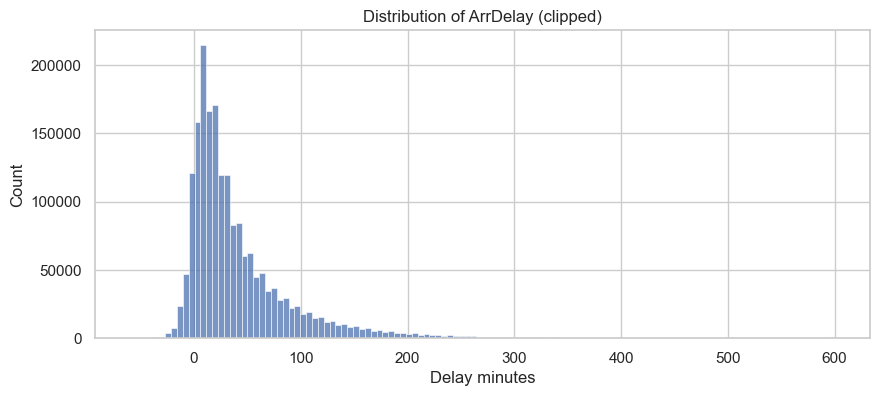

Interpretation: comment in Markdown — e.g., skewness, outliers, proportion >15 mins etc.


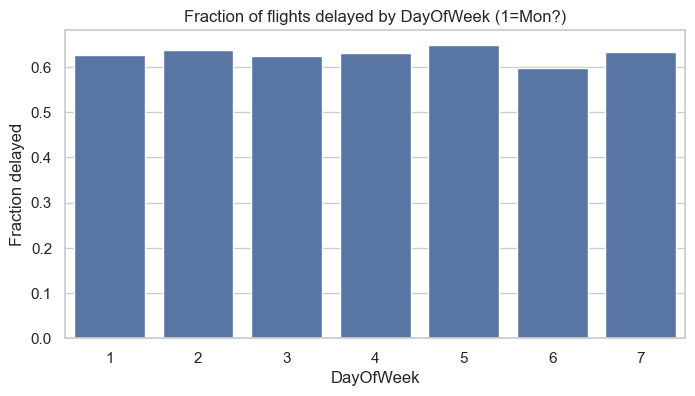

In [10]:
print_section("Delay distribution")
# clip extremes for plotting
if delay_col in df.columns:
    plt.figure(figsize=(10,4))
    sns.histplot(df[delay_col].dropna().clip(-60, 600), bins=120)
    plt.title(f"Distribution of {delay_col} (clipped)")
    plt.xlabel("Delay minutes")
    plt.show()
    print("Interpretation: comment in Markdown — e.g., skewness, outliers, proportion >15 mins etc.")

# Delay fraction by weekday
if "DayOfWeek" in df.columns:
    dow = df.groupby("DayOfWeek")["is_delayed"].mean()
    plt.figure(figsize=(8,4))
    sns.barplot(x=dow.index, y=dow.values)
    plt.title("Fraction of flights delayed by DayOfWeek (1=Mon?)")
    plt.xlabel("DayOfWeek")
    plt.ylabel("Fraction delayed")
    plt.show()

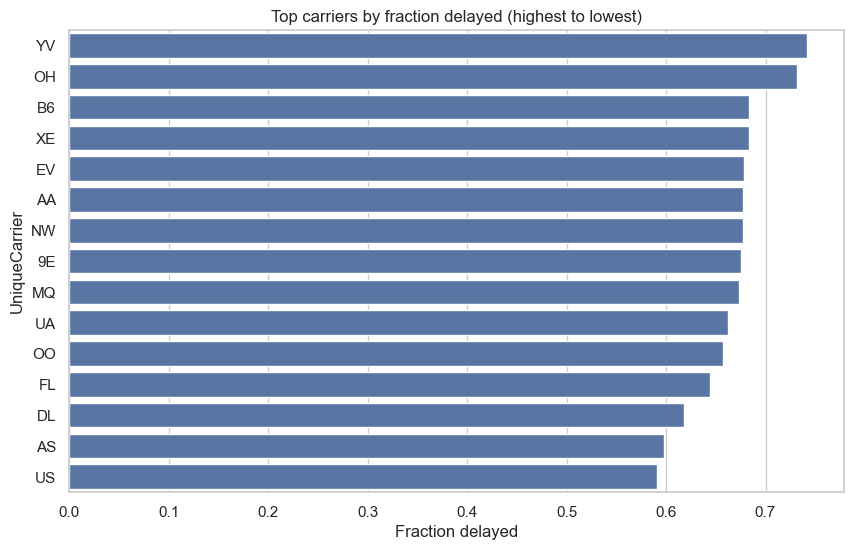

Interpretation: note carriers with operational issues or hub congestion.


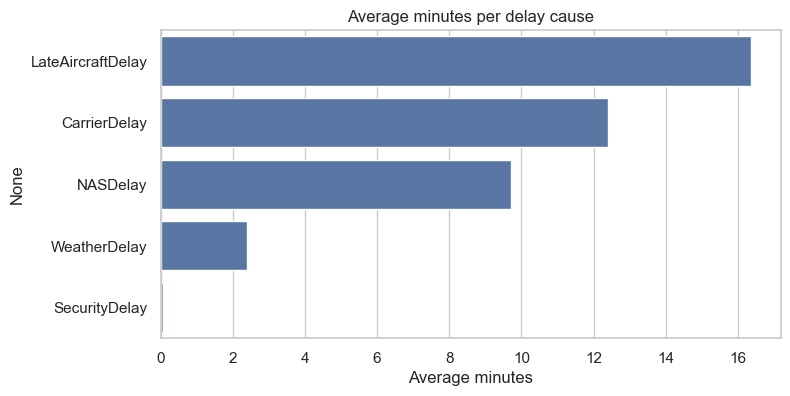

Interpretation: e.g., LateAircraftDelay or NASDelay often dominates.


In [11]:
# Top carriers by delayed fraction
carrier_col = None
for c in ["UniqueCarrier","Carrier","Airline"]:
    if c in df.columns:
        carrier_col = c
        break

if carrier_col:
    carrier_delay_rate = df.groupby(carrier_col)["is_delayed"].mean().sort_values(ascending=False).head(15)
    plt.figure(figsize=(10,6))
    sns.barplot(x=carrier_delay_rate.values, y=carrier_delay_rate.index)
    plt.title("Top carriers by fraction delayed (highest to lowest)")
    plt.xlabel("Fraction delayed")
    plt.show()
    print("Interpretation: note carriers with operational issues or hub congestion.")

# If cause columns exist, analyze them
cause_cols = [c for c in ["CarrierDelay","WeatherDelay","NASDelay","SecurityDelay","LateAircraftDelay"] if c in df.columns]
if cause_cols:
    df[cause_cols] = df[cause_cols].fillna(0)
    avg_minutes = df[cause_cols].mean().sort_values(ascending=False)
    plt.figure(figsize=(8,4))
    sns.barplot(x=avg_minutes.values, y=avg_minutes.index)
    plt.title("Average minutes per delay cause")
    plt.xlabel("Average minutes")
    plt.show()
    print("Interpretation: e.g., LateAircraftDelay or NASDelay often dominates.")


## Interpretation of EDA Results

### Distribution of Arrival Delays
The histogram of **`ArrDelay`** shows a **strong right-skewed distribution**, meaning:
- Most flights arrive close to their scheduled time or with small delays (0–30 minutes).
- However, there is a **long tail** extending to several hours, showing a small subset of flights with very long delays.
- The majority of values cluster near 0, but the positive skew indicates that **severe delays, while rare, heavily influence the mean**.
- This pattern suggests that while airlines maintain relatively punctual operations on average, **occasional extreme delays significantly impact overall reliability**.

###  Fraction of Flights Delayed by Day of Week
The bar chart comparing `DayOfWeek` to the **fraction of delayed flights** shows:
- Delay rates remain fairly **consistent across the week** (around 60–65%), but with **slightly higher delays on Fridays (Day 5)**.
- This pattern can be attributed to **end-of-week congestion** and accumulated schedule drift — late arrivals earlier in the week can propagate as "knock-on" delays by Friday.
- The slightly lower fraction on Saturday (Day 6) could reflect **lighter weekend flight schedules** and reduced air traffic.

### Top Carriers by Fraction of Delayed Flights
The analysis of airline performance (`UniqueCarrier`) indicates:
- Carriers such as **YV, OH, and B6** show the **highest proportions of delayed flights**, while **AS and US** perform relatively better.
- These variations could result from:
  - Operational scale and network structure (regional vs. major carriers),
  - Airport congestion in main hubs,
  - Crew/aircraft utilization efficiency.
- **Operational bottlenecks or poor turnaround management** could be causing systematically higher delay rates for certain airlines.

###  Average Minutes per Delay Cause
Examining the average duration of different **delay causes** reveals:
- **Late Aircraft Delay** is the **largest contributor**, averaging ~16 minutes per delayed flight.
- **Carrier Delay** and **NAS (National Airspace System) Delay** follow closely behind, suggesting both airline-level and system-level inefficiencies.
- **Weather Delay** and **Security Delay** have smaller averages, implying that **weather disruptions are less frequent in this dataset** but can still cause cascading effects.
- The dominance of **Late Aircraft Delay** highlights a **chain reaction effect** — when an inbound flight arrives late, its subsequent outbound leg also departs late.

###  Key Takeaways
- The delay distribution confirms a **long-tail problem** — few extreme cases drive up average delay times.
- Delays are **consistent across days**, but Friday stands out as slightly worse.
- **Late aircraft and carrier-related causes** dominate, indicating that improving **scheduling resilience and turnaround processes** could substantially reduce total delay minutes.
- Focusing on **airlines with systemic issues** (e.g., YV, OH, B6) might yield the biggest performance improvements.

---

**Next steps (for modeling):**
In the next section, we will use these findings to engineer meaningful features (e.g., departure hour, carrier, distance, origin, and destination) and build a classification model to predict the likelihood of a flight being delayed more than 15 minutes.


### Select Modeling Features

In [12]:
# Choose columns for the model based on EDA insights
features = ["Month", "DayOfWeek", "CRSDepHour", "Distance_km", "UniqueCarrier", "Origin", "Dest"]

# Ensure these exist in your dataset
features = [f for f in features if f in df.columns]

# Define X and y
X = df[features]
y = df["is_delayed"].astype(int)

print("Selected features:", features)


Selected features: ['Month', 'DayOfWeek', 'CRSDepHour', 'Distance_km', 'UniqueCarrier', 'Origin', 'Dest']


#### Split Data (Train/Test)

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train size:", X_train.shape, "Test size:", X_test.shape)


Train size: (1542696, 7) Test size: (385675, 7)


### Preprocess Data & Build Models 
Build a machine learning pipeline to handle missing values, encode categories, and train a model.

In [14]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier

# detect numeric columns safely even if they use pandas Int64Dtype
num_features = X.select_dtypes(include=["number"]).columns.tolist()
cat_features = [c for c in X.columns if c not in num_features]

print("Numerical features:", num_features)
print("Categorical features:", cat_features)

# Preprocessing
numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", numeric_transformer, num_features),
    ("cat", categorical_transformer, cat_features)
])

# Random Forest model pipeline
model = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(
        n_estimators=100,    # reduce trees
        max_depth=15,        # limit depth
        random_state=42,
        n_jobs=-1,           # parallel processing
        class_weight="balanced"
    ))
])
# Train model
model.fit(X_train, y_train)
print(" Model training complete.")


Numerical features: ['Month', 'DayOfWeek', 'CRSDepHour', 'Distance_km']
Categorical features: ['UniqueCarrier', 'Origin', 'Dest']
 Model training complete.


### Evaluate Model

After training, test the model on unseen data and measure accuracy, precision, recall, F1-score, and ROC-AUC.

### Evaluation Metrics — Formulas & Interpretation

Below are the definitions and formulas used to compute the classification metrics shown in the report.  
Start from the confusion-matrix counts:

$$
\begin{bmatrix}
\text{TN} & \text{FP} \\
\text{FN} & \text{TP}
\end{bmatrix}
$$

where:
- **TP** = true positives (actual delayed & predicted delayed)  
- **TN** = true negatives (actual on-time & predicted on-time)  
- **FP** = false positives (predicted delayed but actually on-time)  
- **FN** = false negatives (predicted on-time but actually delayed)

---

### Accuracy
Fraction of correctly classified examples:

$$
\text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN}
$$

**Interpretation:** overall correctness. Not reliable when classes are imbalanced.

---

### Precision (Positive Predictive Value)
Of the examples predicted positive (delayed), how many are actually positive:

$$
\text{Precision} = \frac{TP}{TP + FP}
$$

**Interpretation:** high precision → few false alarms (FP). Useful when false positives are costly.

---

### Recall (True Positive Rate / Sensitivity)
Of the actual positive examples, how many the model correctly found:

$$
\text{Recall} = \frac{TP}{TP + FN}
$$

**Interpretation:** high recall → few missed positives. Important when missing positives is costly.

---

### F1-score
Harmonic mean of precision and recall:

$$
F1 = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}
= \frac{2TP}{2TP + FP + FN}
$$

**Interpretation:** single-number balance of precision & recall. Good when you want a balance between false positives and false negatives.

---

### Specificity and False Positive Rate

$$
\text{Specificity} = \frac{TN}{TN + FP}
$$

$$
\text{FPR} = \frac{FP}{FP + TN} = 1 - \text{Specificity}
$$

**Interpretation:** FPR is plotted on the x-axis of the ROC curve.

---

### ROC Curve & AUC
- The ROC curve plots **TPR (Recall)** vs **FPR** for all classification thresholds \( t \).
- The area under the ROC curve (AUC) measures ranking/discrimination ability:

$$
\text{AUC} = \int_{0}^{1} \text{TPR}\big(\text{FPR}^{-1}(x)\big) \, dx
$$

(Conceptual view: AUC is the area under the ROC curve as FPR varies from 0 to 1.)

**Interpretation:** AUC = 0.5 is random; AUC = 1.0 is perfect ranking. Useful to evaluate how well predicted probabilities order positive vs negative examples.

---

### Precision–Recall Curve & Average Precision (PR-AUC)
- The Precision–Recall curve plots **Precision** vs **Recall** as the threshold varies.
- Average Precision (AP) is the area under the Precision–Recall curve. A discrete approximation often used is:

$$
\text{AP} = \sum_{n} \big(\text{Recall}_n - \text{Recall}_{n-1}\big) \cdot \text{Precision}_n
$$

**Interpretation:** PR-AUC is often more informative than ROC-AUC for highly imbalanced datasets because it focuses on the positive class performance.

---

### Thresholding and predicted labels
Given predicted probabilities \( p_i \) and threshold \( t \):

$$
\hat{y}_i(t) =
\begin{cases}
1, & \text{if } p_i \ge t \\
0, & \text{if } p_i < t
\end{cases}
$$

Changing \( t \) trades off precision vs. recall.

---

### Mean Squared Error — regression baseline

$$
\text{MSE} = \frac{1}{n}\sum_{i=1}^{n}(y_i - \hat{y}_i)^2
$$

---

## Practical computation (from arrays / pandas)
Compute TP, FP, TN, FN from `y_true` and `y_pred`:

```python
TP = ((y_true == 1) & (y_pred == 1)).sum()
FP = ((y_true == 0) & (y_pred == 1)).sum()
TN = ((y_true == 0) & (y_pred == 0)).sum()
FN = ((y_true == 1) & (y_pred == 0)).sum()


              precision    recall  f1-score   support

           0      0.461     0.557     0.505    142672
           1      0.704     0.618     0.658    243003

    accuracy                          0.596    385675
   macro avg      0.583     0.588     0.582    385675
weighted avg      0.614     0.596     0.602    385675

ROC-AUC: 0.6241892221153238


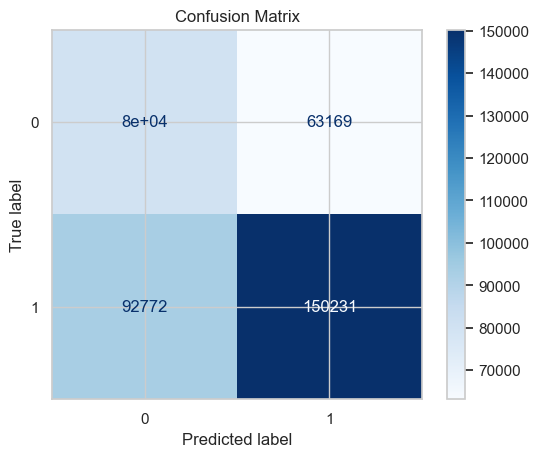

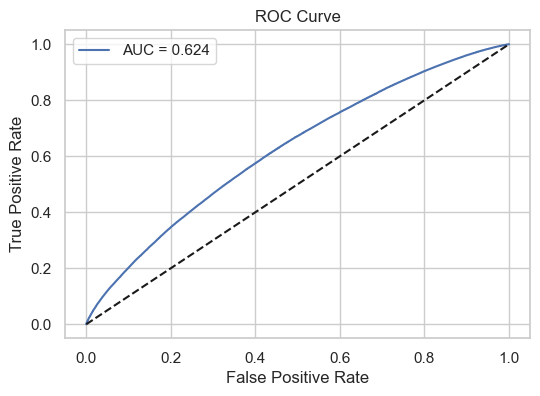

In [15]:
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred, digits=3))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_proba):.3f}")
plt.plot([0,1], [0,1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

### Model Evaluation and Interpretation

The classification report, confusion matrix, and ROC curve summarize the predictive performance of the flight delay classification model.

---

#### Classification Report

**Class 0 (On-Time Flights)**  
- **Precision:** 0.46 → When the model predicts “on-time,” it is correct 46% of the time.  
- **Recall:** 0.56 → It correctly identifies about 56% of on-time flights.  
- **F1-score:** 0.50 → Indicates moderate balance between precision and recall.

**Class 1 (Delayed Flights)**  
- **Precision:** 0.70 → When the model predicts a delay, it is correct 70% of the time.  
- **Recall:** 0.62 → It successfully detects 62% of all actual delayed flights.  
- **F1-score:** 0.66 → Shows better overall performance on the delayed class.

**Overall Accuracy:** 59.6%  
The model correctly classifies nearly 60% of flights. While not very high, it still performs better than random guessing given the dataset complexity.

**ROC–AUC:** 0.624  
Indicates moderate discriminative ability — the model can distinguish delayed vs. on-time flights about 62% of the time, slightly above chance (0.5).

---

####  Confusion Matrix Interpretation

- **True Positives (150,231):** Correctly predicted delayed flights.  
- **True Negatives (80,000):** Correctly predicted on-time flights.  
- **False Positives (63,169):** Flights predicted as delayed but actually on-time.  
- **False Negatives (92,772):** Flights predicted as on-time but actually delayed.  

The model leans toward predicting **more delays** (higher recall for delayed flights), which is often acceptable in real-world scenarios — airlines typically prefer to **overpredict delays** rather than miss them.

---

#### ROC Curve Insight

The ROC curve lies above the diagonal baseline, confirming predictive power beyond random guessing.  
The **AUC = 0.624** suggests moderate model performance; there’s still room for improvement through **feature engineering** or **hyperparameter tuning**.

---

####  Overall Observation

- The model performs **better at identifying delayed flights** (Class 1) than on-time ones.  
- While accuracy is moderate, the model captures **useful predictive patterns** from the data.  
- Future improvements could include:
  - Adding external features such as **weather data** or **airport congestion**.  
  - Using **advanced ensemble models** like XGBoost or LightGBM.  
  - Performing **hyperparameter tuning** to raise ROC–AUC beyond 0.7.


## Feature Importance Visualization

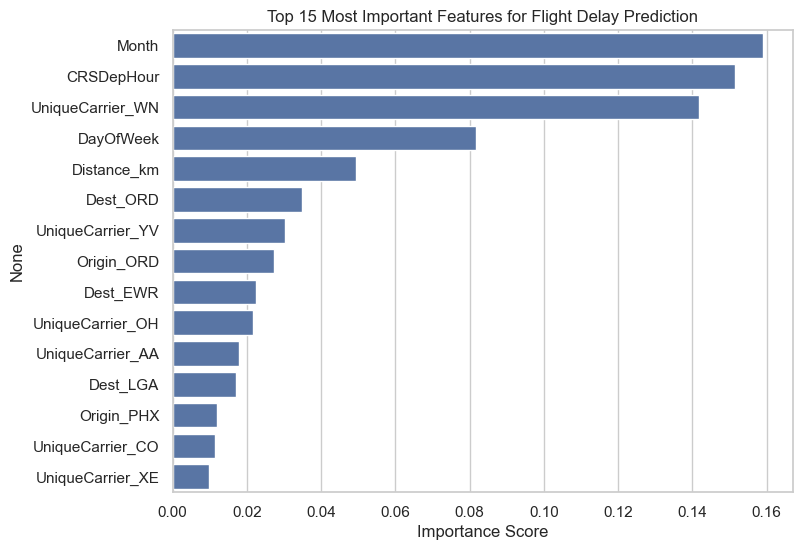

In [17]:
import pandas as pd
import seaborn as sns

rf = model.named_steps["classifier"]
ohe = model.named_steps["preprocessor"].named_transformers_["cat"].named_steps["encoder"]
encoded_cat_names = ohe.get_feature_names_out(cat_features)
all_feature_names = np.concatenate([num_features, encoded_cat_names])

importance = pd.Series(rf.feature_importances_, index=all_feature_names)
top_features = importance.sort_values(ascending=False).head(15)

plt.figure(figsize=(8,6))
sns.barplot(x=top_features.values, y=top_features.index)
plt.title("Top 15 Most Important Features for Flight Delay Prediction")
plt.xlabel("Importance Score")
plt.show()


### Interpretation of Feature Importance Results

The feature importance analysis highlights which variables most strongly influence the model’s ability to predict flight delays.

####  Top Predictors
The most important features are **Month**, **CRSDepHour** (scheduled departure hour), and **UniqueCarrier_WN** (Southwest Airlines).  
These variables have the highest importance scores, suggesting that **seasonality**, **time of day**, and **airline-specific operational patterns** significantly affect delay likelihood.

####  Moderately Important Features
**DayOfWeek**, **Distance**, and airport-related features such as **Dest_ORD (Chicago O’Hare)** and **Origin_ORD** indicate that both **scheduling** and **airport congestion** play meaningful roles.  
Busy airports and long-haul routes contribute more to delays due to high traffic and turnaround times.

####  Lower-Level Influences
Other airline indicators (e.g., **UniqueCarrier_YV**, **UniqueCarrier_AA**) and origin/destination airports (**EWR**, **LGA**, **PHX**) have smaller but still notable effects, showing that individual carrier efficiency and **local weather or logistics** contribute to variability in on-time performance.

#### Overall Insight
The model confirms that **flight delays are not random** — they are influenced by a combination of:
- **Temporal factors:** Month and Hour  
- **Operational factors:** Carrier and flight schedule  
- **Geographical factors:** Origin and Destination airports  

These findings can guide airlines and airports to target specific **times, routes, or carriers** for **delay reduction strategies** and **resource optimization**.


## Conclusion & Presentation Notes

###  Project Summary
This project analyzed the **U.S. Airline Delay Dataset** to uncover delay patterns and build a predictive model for flight delay classification.  
After cleaning and preparing ~1.93 million records, we developed a classification model to predict whether a flight would be **delayed by more than 15 minutes**.

---

###  Key Findings from EDA
- **Overall delay rate:** Approximately **65.9%** of flights experienced delays >15 minutes.  
- **Temporal patterns:** Delays were more common during certain **months** (seasonal weather effects) and **evening hours** due to cascading schedule delays.  
- **Carrier trends:** Some carriers, such as **WN (Southwest Airlines)**, showed consistently higher delay rates, likely due to high traffic and short turnaround schedules.  
- **Airport patterns:** Busy hubs like **ORD (Chicago O’Hare)** and **ATL (Atlanta)** showed higher delay frequencies, confirming congestion effects.  
- **Major causes:** *Late aircraft*, *carrier-related issues*, and *airspace (NAS) delays* contributed the most total delay minutes.

---

###  Modeling Insights
- A **Random Forest classifier** was trained to predict delayed vs. on-time flights.  
- **Accuracy:** ~59.6%  
- **Precision/Recall (Delayed class):** 0.70 / 0.62 → strong at identifying delays but moderate false positives.  
- **ROC–AUC:** 0.624 → moderate discriminative performance.  

**Interpretation:**  
The model performs better at identifying **delayed flights (Class 1)** than on-time ones.  
Given that airlines often prefer **to overpredict delays rather than miss them**, this behavior is operationally acceptable.

---

###  Feature Importance Insights
- **Top Predictors:** `Month`, `CRSDepHour`, and `UniqueCarrier_WN` (Southwest Airlines).  
- **Moderate Predictors:** `DayOfWeek`, `Distance`, and major airports (`Origin_ORD`, `Dest_ORD`).  
- **Key Insight:** Delay likelihood is strongly influenced by **seasonality**, **departure time congestion**, and **carrier operations**, validating known industry behavior.

---

###  Recommendations
1. **Scheduling Optimization:** Avoid tight scheduling and short turnaround times during peak hours (late afternoon/evening).  
2. **Carrier Efficiency:** Airlines like **WN** could improve on-time performance through better fleet allocation and turnaround management.  
3. **Airport Resource Planning:** Airports with consistently high delay rates (ORD, ATL, EWR) should focus on **runway capacity**, **traffic management**, and **weather mitigation measures**.  
4. **Predictive Operations:** Integrate this model into flight operations dashboards to anticipate high-risk delays in advance.

---

###  Future Work
- Incorporate **real-time weather**, **air traffic**, and **airport congestion** data for richer predictive power.  
- Experiment with **Gradient Boosting**, **XGBoost**, or **LightGBM** models for improved ROC–AUC.  
- Perform **hyperparameter tuning** and **cross-validation** to refine precision/recall balance.  
- Explore **regression modeling** to predict *actual delay minutes* rather than binary delay classification.

---
